In [1]:
import numpy as np
import scipy.integrate as integrate
from scipy.constants import c
import pandas as pd
from matplotlib import pyplot as plt
import random
from tqdm import tqdm

# Distance Modulus and Luminosity Distance

The **distance modulus** (\(\mu\)) of a supernova is given by:

$$
\mu = m - M
$$

where:  
- \( m \) is the apparent magnitude of the supernova (how bright it appears from Earth).  
- \( M \) is the absolute magnitude (its intrinsic brightness).  

The distance modulus relates to the luminosity distance \( d_L \) (in parsecs) through:

$$
\mu = 5 \log_{10}(d_L) + 25
$$

## Cosmological Luminosity Distance

For cosmological supernovae, the luminosity distance depends on the cosmological parameters $( H_0, \Omega_m, \Omega_\Lambda )$ and redshift (\( z \)):

$$
d_L(z) = (1+z) \int_0^z \frac{c \, dz'}{H(z')}
$$

where:

$$
H(z) = H_0 \sqrt{\Omega_m(1+z)^3 + \Omega_\Lambda}
$$


In [2]:
# Convert speed of light to km/s
c_km_s = c / 1e3

def H(z, H0, Omega_m):
    """Hubble parameter H(z) in km/s/Mpc"""
    Omega_l = 1 - Omega_m
    return H0 * np.sqrt(Omega_m * (1 + z)**3 + Omega_l)

# Function to compute d_L(z) in Mparsec (same as Mpc)
def luminosity_distance(z,H0,Omega_m):
    """
    Compute the luminosity distance d_L(z) in Megaparsecs (Mparsec).
    
    Parameters:
        z (float): Redshift
        
    Returns:
        float: Luminosity distance in Mparsec (Mpc)
    """
    integral, _ = integrate.quad(lambda z_prime: c_km_s / H(z_prime,H0,Omega_m), 0, z)
    return (1 + z) * integral  # Result is in Mparsec (Mpc)

def distance_modulus(z, H0, Omega_m):
    d_L = luminosity_distance(z, H0, Omega_m)  # Luminosity distance in Mpc
    return 5 * np.log10(d_L) + 25  # Distance modulus

# Example: Compute d_L for z = 1
z_example = 1
Omega_m = 0.7
H0 = 70
d_L_example = luminosity_distance(z_example,H0,Omega_m)
d_mod = distance_modulus(z_example, H0, Omega_m)
print(f"Luminosity distance at z={z_example}: {d_L_example:.2f} Mparsec")
print(f"distance modulus at z={z_example}: {d_mod:.2f} ")


Luminosity distance at z=1: 5512.32 Mparsec
distance modulus at z=1: 43.71 


In [3]:
file_path = "Pantheon - Scolnic SNe 1A 1048 z-asc 27May'19.xlsx"
df = pd.read_excel(file_path, engine="openpyxl", skiprows=1)

print(df.head())


    #name     zcmb     zhel  dz        mb      dmb
0  2002cr  0.01012  0.01012   0  13.90745  0.19825
1  2002dp  0.01038  0.01038   0  14.04960  0.20480
2  2009an  0.01043  0.01043   0  13.92480  0.20035
3  2006bh  0.01082  0.01082   0  14.00860  0.18445
4  1998dk  0.01209  0.01209   0  13.97910  0.19140


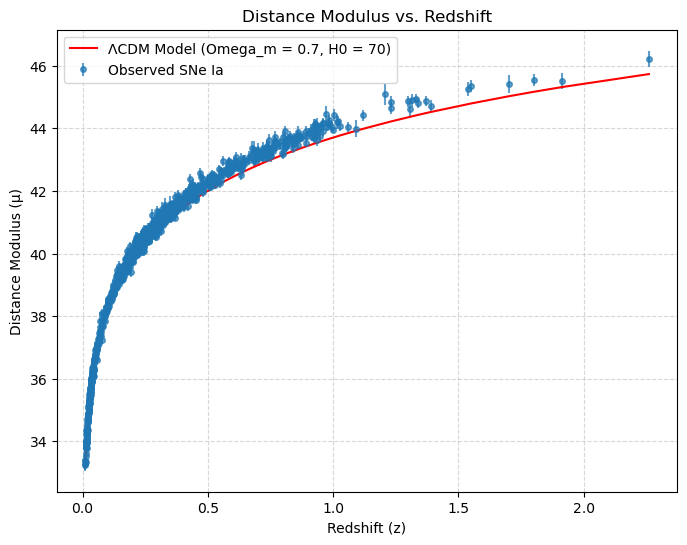

In [4]:
# Extract relevant columns
z_data = df["zcmb"].values  # Redshift
mu_data = df["mb"].values + 19.35  # Distance modulus
mu_err = df["dmb"].values 

# Compute theoretical distance modulus using z_data directly
mu_theory = [distance_modulus(z, H0, Omega_m) for z in z_data]

# Plot
plt.figure(figsize=(8, 6))
plt.errorbar(z_data, mu_data, yerr=mu_err, fmt="o", markersize=4, alpha=0.7, label="Observed SNe Ia")
plt.plot(z_data, mu_theory, color="red", linestyle="-", linewidth=1.5, label="ΛCDM Model (Omega_m = 0.7, H0 = 70)")
plt.xlabel("Redshift (z)")
plt.ylabel("Distance Modulus (μ)")
plt.title("Distance Modulus vs. Redshift")
# plt.xscale("log")  # Log scale for better visualization
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.show()


In [5]:
# Chi-square function
def chi_square(H0, Omega_m, z_data, mu_data, mu_err):
    mu_model = np.array([distance_modulus(z, H0, Omega_m) for z in z_data])
    return np.sum(((mu_data - mu_model) / mu_err) ** 2)
    

In [6]:
# MCMC parameters
random.seed(10)
n_iterations = 10000
H0_range = (30, 80)
Omega_m_range = (0, 1)
# H0_current = np.random.uniform(*H0_range)
# Omega_m_current = np.random.uniform(*Omega_m_range)
H0_current = 63
Omega_m_current = .12
print(H0_current,Omega_m_current)

63 0.12


In [21]:
chi_current = chi_square(H0_current, Omega_m_current, z_data, mu_data, mu_err)

# Step sizes
sigma_H0 = 0.1
sigma_Omega_m = 0.01

# Store results
samples = []
chi_values = []  # Store chi-square values

for i in tqdm(range(n_iterations)):
    # Propose new values
    H0_proposed = np.random.normal(H0_current, sigma_H0)
    Omega_m_proposed = np.random.normal(Omega_m_current, sigma_Omega_m)

    # Ensure within bounds
    if not (H0_range[0] <= H0_proposed <= H0_range[1]):
        continue
    if not (Omega_m_range[0] <= Omega_m_proposed <= Omega_m_range[1]):
        continue

    # Compute chi-square for proposed values
    chi_proposed = chi_square(H0_proposed, Omega_m_proposed, z_data, mu_data, mu_err)
    
    # Metropolis-Hastings acceptance criterion
    if chi_proposed < chi_current:
        H0_current = H0_proposed
        Omega_m_current = Omega_m_proposed
        chi_current = chi_proposed
    else:
        accept_prob = np.exp(-0.5 * (chi_proposed - chi_current))
        if np.random.rand() < accept_prob:
            H0_current = H0_proposed
            Omega_m_current = Omega_m_proposed
            chi_current = chi_proposed
    
    # Store sample and chi-square value
    samples.append((H0_current, Omega_m_current))
    chi_values.append(chi_current)  # Store χ² value

# Convert samples to array
samples = np.array(samples)
chi_values = np.array(chi_values)  # Convert chi-square list to array



100%|█████████████████████████████████████| 10000/10000 [04:53<00:00, 34.09it/s]


In [22]:
len(chi_values)

10000

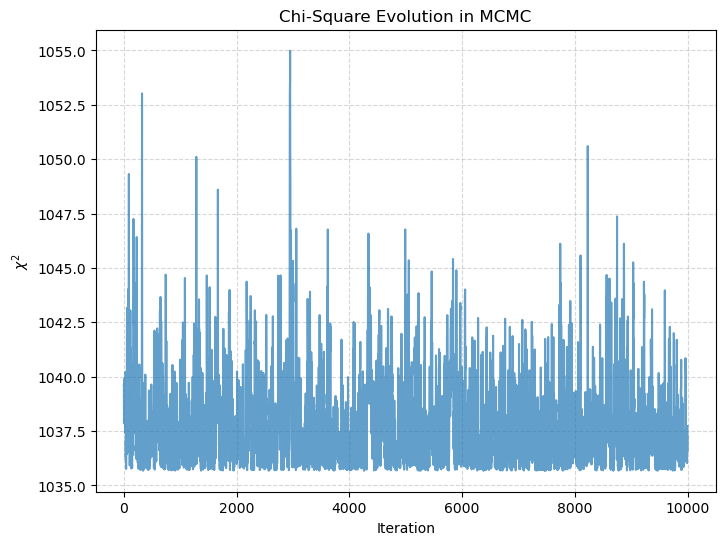

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(chi_values, alpha=0.7, linewidth=1.5)
plt.xlabel("Iteration")
plt.ylabel(r"$\chi^2$")
plt.title(r"Chi-Square Evolution in MCMC")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


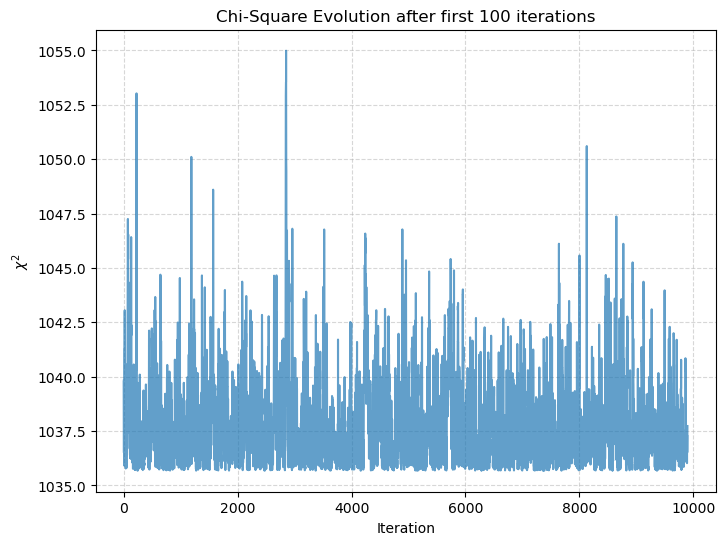

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(chi_values[100:], alpha=0.7, linewidth=1.5)
plt.xlabel("Iteration")
plt.ylabel(r"$\chi^2$")
plt.title(r"Chi-Square Evolution after first 100 iterations")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


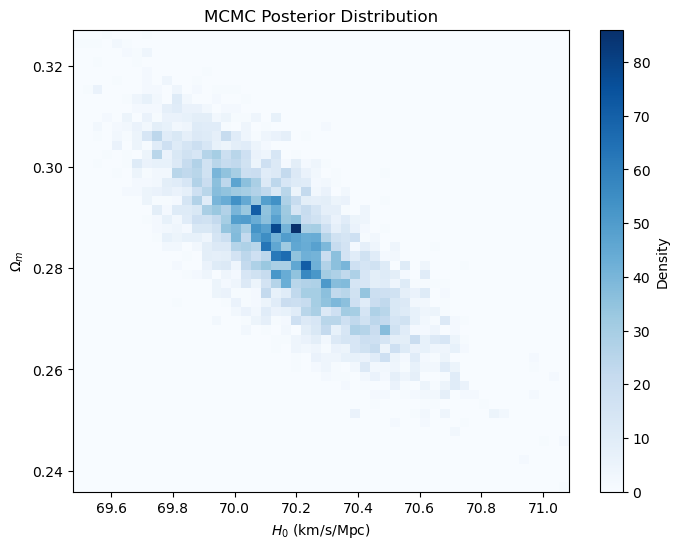

In [25]:
# Plot results
plt.figure(figsize=(8, 6))
plt.hist2d(samples[1000:, 0], samples[1000:, 1], bins=50, cmap="Blues")
plt.xlabel(r"$H_0$ (km/s/Mpc)")
plt.ylabel(r"$\Omega_m$")
plt.title("MCMC Posterior Distribution")
plt.colorbar(label="Density")
plt.show()

# Best-fit values
H0_best, Omega_m_best = np.mean(samples, axis=0)


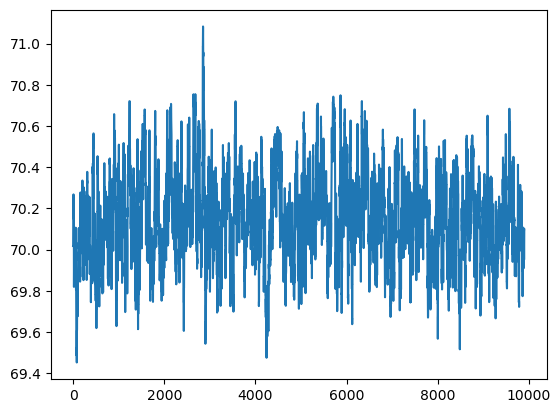

In [26]:
plt.plot(samples[100:,0])

In [27]:
# Select the last 2000 samples (ensure you have at least 2000 samples)
last_samples = samples[100:]

# Compute best-fit values as the mean of the last samples
H0_best, Omega_m_best = np.mean(last_samples, axis=0)

print(f"Best-fit H0: {H0_best:.2f}")
print(f"Best-fit Omega_m: {Omega_m_best:.3f}")

# Extract H0 and Omega_m samples from the last 2000 samples
H0_samples = last_samples[:, 0]
Omega_m_samples = last_samples[:, 1]

# Compute mean and standard deviation for uncertainty estimation
H0_mean = np.mean(H0_samples)
H0_std = np.std(H0_samples)
Omega_m_mean = np.mean(Omega_m_samples)
Omega_m_std = np.std(Omega_m_samples)

print(f"H0 = {H0_mean:.2f} ± {H0_std:.2f}")
print(f"Omega_m = {Omega_m_mean:.3f} ± {Omega_m_std:.3f}")


Best-fit H0: 70.15
Best-fit Omega_m: 0.286
H0 = 70.15 ± 0.22
Omega_m = 0.286 ± 0.012


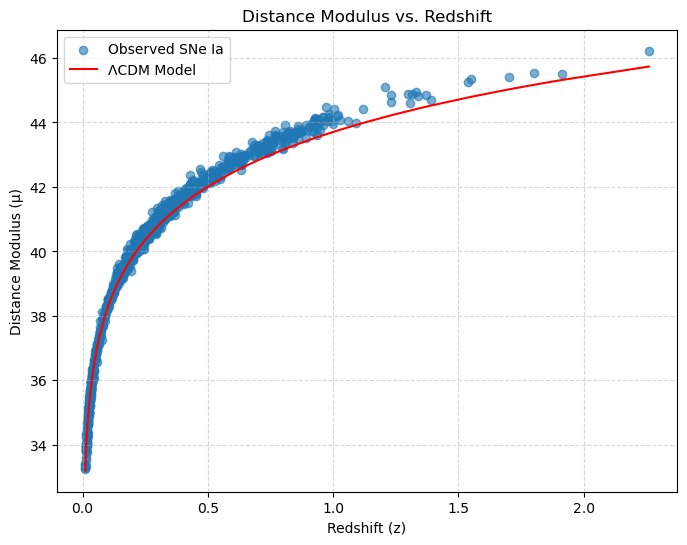

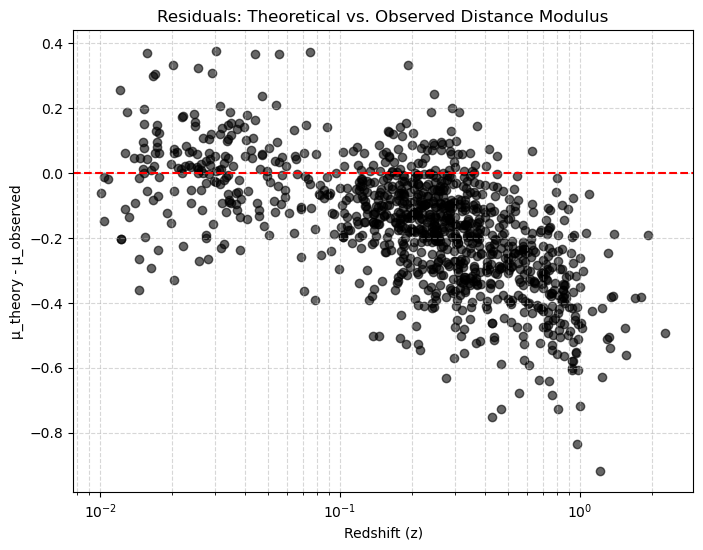

In [28]:
# Compute theoretical and calculated distance modulus
mu_theory = np.array([distance_modulus(z, H0, Omega_m) for z in z_data])
mu_calculated = mu_data  # Assuming this is the observed distance modulus

# Plot 1: Observed vs Theoretical Distance Modulus
plt.figure(figsize=(8, 6))
plt.scatter(z_data, mu_calculated, label="Observed SNe Ia", alpha=0.6, marker="o")
plt.plot(z_data, mu_theory, color="red", linestyle="-", linewidth=1.5, label="ΛCDM Model")
plt.xlabel("Redshift (z)")
plt.ylabel("Distance Modulus (μ)")
# plt.xscale("log")
plt.title("Distance Modulus vs. Redshift")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.show()

# Plot 2: Residuals (mu_theory - mu_calculated)
residuals = mu_theory - mu_calculated

plt.figure(figsize=(8, 6))
plt.scatter(z_data, residuals, color="black", alpha=0.6)
plt.axhline(y=0, color="red", linestyle="--", linewidth=1.5)  # Reference line at 0
plt.xlabel("Redshift (z)")
plt.ylabel("μ_theory - μ_observed")
plt.xscale("log")
plt.title("Residuals: Theoretical vs. Observed Distance Modulus")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.show()
